In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers

In [7]:
class NdMixer(layers.Layer):
    "N-dimensional MLP mixer, without batchnorm or skip connections."

    def __init__(self, outshape: tuple, Net: layers.Layer, 
                 order: tuple=None, gate: bool=True):
        """ 
        Args:
            outshape: The output shape, not including samples dimension. 
                Must have same dimensionality as input.

            order: Order that dimensions are processed.
                Like Keras' Permutation, doesn't include samples dimension.
        """
        super().__init__()
        self.ndim = len(outshape)
        self.order = order if order else range(1, len(outshape)+1)
        self.nets = [Net(size) for size in outshape] 
        self.gate = ScalarGate() if gate else lambda x: x

    def __call__(self, input):
        h = input
        for i in self.order:
            h = apply_net_to_axis(h, self.nets[i - 1], i)
        return self.gate(h)

class ScalarGate(layers.Layer):
    def __init__(self):
        super().__init__()
        self.value = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        return self.value * inputs

class MLP(layers.Layer):
    def __init__(self, outsize, hidden_size=None):
        super().__init__()
        hidden_size = hidden_size if hidden_size else outsize
        self.layer_1 = layers.Dense(hidden_size, activation=tf.nn.gelu)
        self.layer_2 = layers.Dense(outsize)

    def call(self, inputs):
        h = self.layer_1(inputs)
        return self.layer_2(h)

def apply_net_to_axis(x, net, axis):
    perm = list(range(len(x.shape)))
    perm[axis], perm[-1] = perm[-1], perm[axis]
    h = tf.transpose(x, perm)
    h = net(h)
    return tf.transpose(h, perm)

class ResidualLayers(layers.Layer):
    def __init__(self, num_layers, make_layer, gamma=0.9):
        super().__init__()
        self.layers = [make_layer() for _ in range(num_layers)]
        self.gamma = gamma

    def call(self, inputs):  # momentum ResNets
        v = 0
        h = inputs
        for layer in self.layers:
            v = self.gamma * v + (1 - self.gamma) * layer(h)
            h = h + v
        return h

class Layers(layers.Layer):
    def __init__(self, num_layers, make_layer):
        super().__init__()
        self.layers = [make_layer() for _ in range(num_layers)]
    
    def call(self, inputs):
        h = inputs
        for layer in self.layers:
            h = layer(h)
        return h

def RowColClf(height, width, num_classes, Net=MLP, name=None):
    "Rather than average pooling, use MLP for rows, cols, then concat."
    inputs = tf.keras.layers.Input(shape=(height, width))
    rows_out = Net(1)(inputs)
    rows_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(rows_out)
    cols_out = tf.keras.layers.Permute([2, 1])(inputs)
    cols_out = Net(1)(cols_out)
    cols_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(cols_out)
    concat = tf.keras.layers.Concatenate()([rows_out, cols_out])
    flat = tf.keras.layers.Flatten()(concat)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)


def autoencoder(shape, num_mix_layers):
    """Autoencoder via mixer layers. Note, skip connections aren't used here, 
    otherwise network is trivially the identity function."""
    inputs = tf.keras.layers.Input(shape)
    h = inputs
    for _ in range(num_mix_layers):
        h = NdMixer(shape, MLP, gate=False)(h)
    return tf.keras.Model(inputs=inputs, outputs=h)


# MNIST

In [8]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)

height, width = train_images.shape[-2:]
num_classes = 10

In [4]:
# Assert that the model is initialised as identify function.
num_mix_layers = 16
make_mixer = lambda: NdMixer([height, width], MLP, gate=True)
inputs = tf.keras.layers.Input(shape=(height, width))
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=mixer_layers)
assert np.sum(model.predict(train_images[0:100, ...]) - train_images[0:100, ...]) == 0

## Classifier

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
tf.compat.v1.transpose_8 (TF (None, 28, 28)            0         
_________________________________________________________________
dense_709 (Dense)            (None, 28, 28)            812       
_________________________________________________________________
tf.compat.v1.transpose_9 (TF (None, 28, 28)            0         
_________________________________________________________________
tf.compat.v1.transpose_10 (T (None, 28, 28)            0         
_________________________________________________________________
dense_710 (Dense)            (None, 28, 28)            812       
_________________________________________________________________
tf.compat.v1.transpose_11 (T (None, 28, 28)            0  

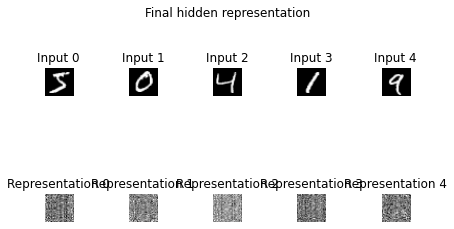

In [ ]:
num_mix_layers = 16
Net = lambda outsize: MLP(outsize, hidden_size=256)
make_mixer = lambda: NdMixer([height, width], Net, gate=True)

inputs = tf.keras.layers.Input(shape=(height, width))
linmap_in = NdMixer([height, width], layers.Dense, gate=False)(inputs)
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(linmap_in)
linmap_out = NdMixer([12, 12], layers.Dense, gate=False)(mixer_layers)  # make a tractable size
flat = tf.keras.layers.Flatten()(linmap_out)
y = tf.keras.layers.Dense(num_classes)(flat)
model = tf.keras.Model(inputs=inputs, outputs=y)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')
plt.show()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
tf.compat.v1.transpose_24 (T (None, 28, 28)            0         
_________________________________________________________________
dense_815 (Dense)            (None, 28, 8)             232       
_________________________________________________________________
tf.compat.v1.transpose_25 (T (None, 8, 28)             0         
_________________________________________________________________
tf.compat.v1.transpose_26 (T (None, 8, 28)             0         
_________________________________________________________________
dense_816 (Dense)            (None, 8, 8)              232       
_________________________________________________________________
tf.compat.v1.transpose_27 (T (None, 8, 8)              0  

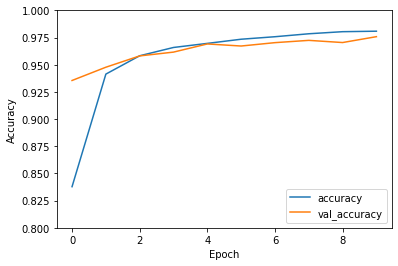

In [ ]:
"With linear mixer to modify the size of the hidden representation (which affects MLP size)."
num_mix_layers = 8
Net = lambda outsize: MLP(outsize, hidden_size=256)
make_mixer = lambda: NdMixer([8, 8], Net, gate=True)

inputs = tf.keras.layers.Input(shape=(height, width))
linmap_in = NdMixer([8, 8], layers.Dense, gate=False)(inputs)
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(linmap_in)
linmap_out = NdMixer([12, 12], layers.Dense, gate=False)(mixer_layers)  # make a tractable size
flat = tf.keras.layers.Flatten()(linmap_out)
y = tf.keras.layers.Dense(num_classes)(flat)
model = tf.keras.Model(inputs=inputs, outputs=y)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')
plt.show()

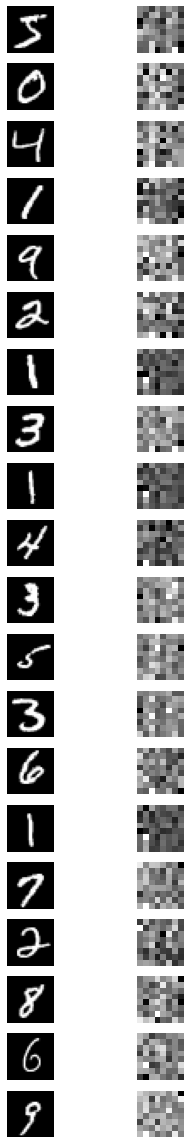

In [ ]:
mixfunc = tf.keras.backend.function([inputs], [mixer_layers])

plt.figure(figsize=(5, 16))
for i in range(20):
    im = train_images[i:i+1,...]

    plt.subplot(20, 2, i*2+1)
    plt.imshow(im[0, ...], vmin=0, vmax=1, cmap='gray')
    plt.axis('off')

    plt.subplot(20, 2, i*2+2)
    plt.imshow(mixfunc(im)[0][0,...], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

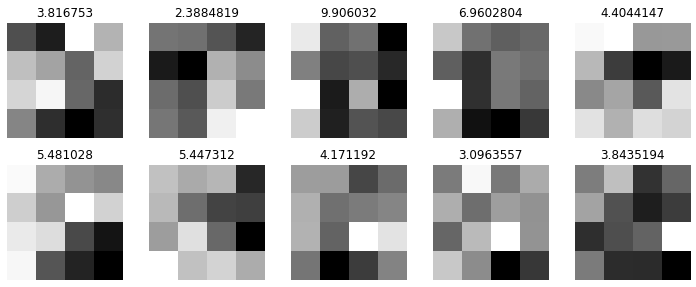

In [ ]:
"Average representations per class."

avgs = []
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    representations = mixfunc(train_images[train_labels==i,...])[0]
    av = np.mean(representations, axis=0)
    plt.title(np.std(representations))
    plt.imshow(av, cmap='gray')

    avgs.append(av)
    plt.axis('off')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Class')

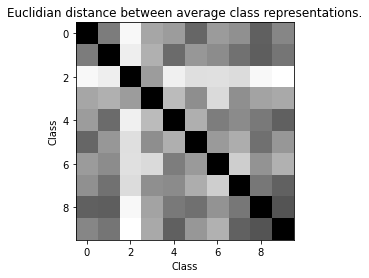

In [ ]:
avgs_np = np.stack(avgs).reshape(10, -1)
diffs = (avgs_np.reshape(10, -1, 16) - avgs_np.reshape(-1, 10, 16))**2
diffs = np.sqrt(np.mean(diffs, axis=-1))
plt.imshow(diffs, cmap='gray')
plt.title('Euclidian distance between average class representations.')
plt.xlabel('Class')
plt.ylabel('Class')

## Autoencoder

Note that skip connections are removed for the autoencoder model, because they would cause the model to be initialised as the identity function, (due to the initial 0 scalar gate), which would make the model trivially an autoencoder.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
layers_1 (Layers)            (None, 28, 28)            6496      
Total params: 6,496
Trainable params: 6,496
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 6s 5ms/step - loss: 0.0354 - root_mean_squared_error: 0.1799 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 3/10
938/938 [==============================] - 4s 5ms/step - loss: 9.0787e-04 - root_mean_squared_error: 0.0301 - val_loss: 6.2453e-04 - val_root_mean_squared_erro

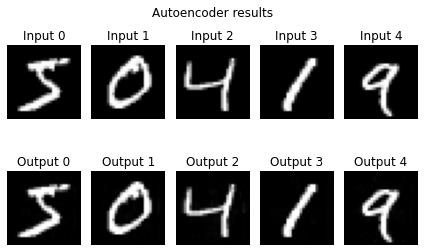

In [10]:
num_mix_layers = 2
Net = lambda outsize: MLP(outsize, hidden_size=outsize)
make_mixer = lambda: NdMixer([height, width], Net, gate=False)

inputs = tf.keras.layers.Input(shape=(height, width))
mixer_layers = Layers(num_mix_layers, make_mixer)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=mixer_layers)

print(model.summary())
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images))

# PLOTS
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

for i in range(5):
    im = train_images[i:i+1,...]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results")
plt.tight_layout()
plt.show()

# CIFAR-10

In [11]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)
height, width, channels = 32, 32, 3
num_classes = 10

170500096/170498071 [==============================] - 11s 0us/step


## Classifier

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.compat.v1.transpose (TFOp (None, 3, 32, 32)         0         
_________________________________________________________________
dense (Dense)                (None, 3, 32, 32)         1056      
_________________________________________________________________
tf.compat.v1.transpose_1 (TF (None, 32, 32, 3)         0         
_________________________________________________________________
tf.compat.v1.transpose_2 (TF (None, 32, 3, 32)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 3, 32)         1056      
_________________________________________________________________
tf.compat.v1.transpose_3 (TF (None, 32, 32, 3)         0     

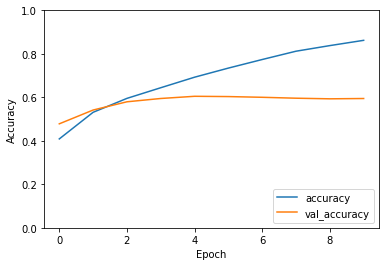

In [ ]:
num_mix_layers = 16
net = lambda outsize: MLP(outsize, hidden_size=128)
make_mixer = lambda: NdMixer([height, width, channels], net, gate=False)

inputs = tf.keras.layers.Input(shape=(height, width, channels))
linmap_in = NdMixer([height, width, channels], layers.Dense, gate=False)(inputs)
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(linmap_in)
linmap_out = NdMixer([20, 20, 1], layers.Dense, gate=False)(mixer_layers)  # make a tractable size
flat = tf.keras.layers.Flatten()(linmap_out)
y = tf.keras.layers.Dense(num_classes)(flat)
model = tf.keras.Model(inputs=inputs, outputs=y)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

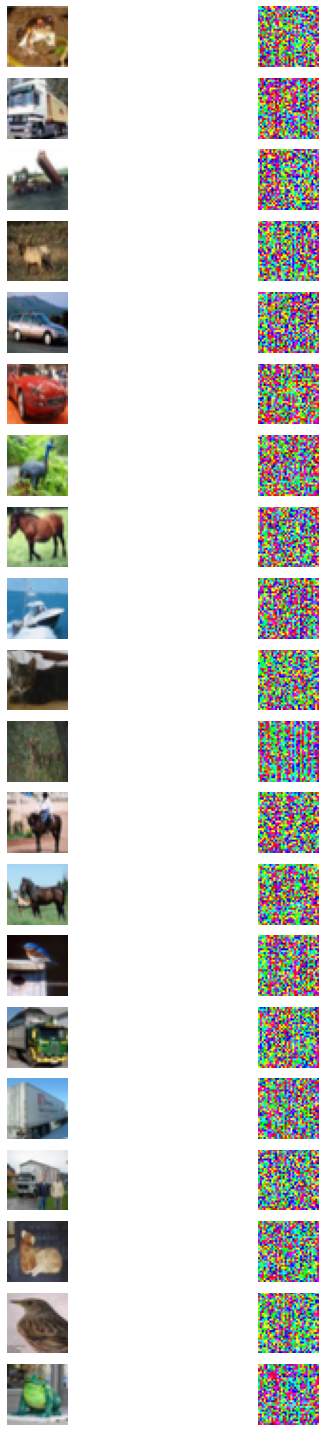

In [ ]:
plt.figure(figsize=(10, 20))
mixfunc = tf.keras.backend.function([inputs], [mixer_layers])
for i in range(20):
    im = train_images[i:i+1,...]
    pred = mixfunc(im)[0][0,...]
    pred_norm = (pred - np.mean(pred)) / np.std(pred) + 0.5
    pred_norm = np.clip(pred_norm, 0, 1)

    plt.subplot(20, 2, i*2+1)
    plt.imshow(im[0, ...], vmin=0, vmax=1)
    plt.axis('off')

    plt.subplot(20, 2, i*2+2)
    plt.imshow(pred_norm)
    plt.axis('off')

plt.tight_layout()
plt.show()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.compat.v1.transpose (TFOp (None, 3, 32, 32)         0         
_________________________________________________________________
dense_80 (Dense)             (None, 3, 32, 64)         2112      
_________________________________________________________________
tf.compat.v1.transpose_1 (TF (None, 64, 32, 3)         0         
_________________________________________________________________
tf.compat.v1.transpose_2 (TF (None, 64, 3, 32)         0         
_________________________________________________________________
dense_81 (Dense)             (None, 64, 3, 64)         2112      
_________________________________________________________________
tf.compat.v1.transpose_3 (TF (None, 64, 64, 3)         0   

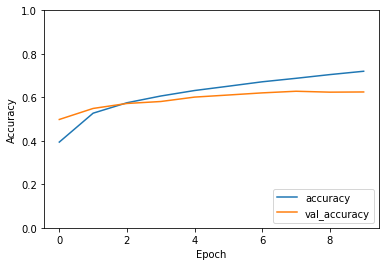

In [12]:
"With linear mapping to modify the size of the hidden representation (and therefore MLP size)."
num_mix_layers = 4
repheight, repwidth = 64, 64
net = lambda outsize: MLP(outsize, hidden_size=outsize)
make_mixer = lambda: NdMixer([repheight, repwidth, channels], net, gate=False)

inputs = tf.keras.layers.Input(shape=(height, width, channels))
linmap_in = NdMixer([repheight, repwidth, channels], layers.Dense, gate=False)(inputs)
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(linmap_in)
linmap_out = NdMixer([20, 20, 1], layers.Dense, gate=False)(mixer_layers)  # make a tractable size
flat = tf.keras.layers.Flatten()(linmap_out)
y = tf.keras.layers.Dense(num_classes)(flat)
model = tf.keras.Model(inputs=inputs, outputs=y)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## Autoencoder

Note that skip connections are removed for the autoencoder model, because they would cause the model to be initialised as the identity function, (due to the initial 0 scalar gate), which would make the model trivially an autoencoder.

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
layers_2 (Layers)            (None, 32, 32, 3)         8496      
Total params: 8,496
Trainable params: 8,496
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 9s 10ms/step - loss: 0.0707 - root_mean_squared_error: 0.2532 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 2/10
782/782 [==============================] - 7s 10ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 3/10
782/782 [==============================] - 7s 10ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0024 - val_root_mean_squared_error: 0.

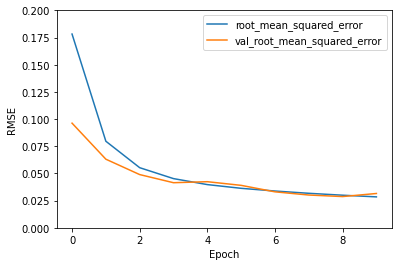

In [13]:
num_mix_layers = 2
Net = lambda outsize: MLP(outsize, hidden_size=outsize)
make_mixer = lambda: NdMixer([height, width, channels], Net, gate=False)

inputs = tf.keras.layers.Input(shape=(height, width, channels))
mixer_layers = Layers(num_mix_layers, make_mixer)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=mixer_layers)

print(model.summary())
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images))

plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

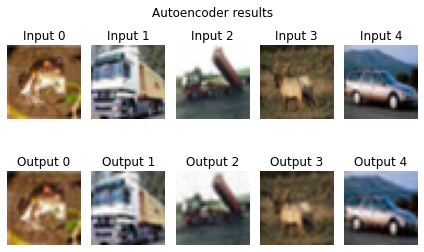

In [15]:
for i in range(5):
    im = train_images[i:i+1, ...]
    pred = model.predict(im)[0,...]
    pred = np.clip(pred, 0, 1)

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(pred, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results")
plt.tight_layout()
plt.show()